In [1]:

%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
import jax
from dataclasses import dataclass
import jax.numpy as jnp
import jax.random as jr

import tensorflow_probability.substrates.jax.bijectors as tfb

#with install_import_hook("gpjax", "beartype.beartype"):
import gpjax as gpx
from gpjax.distributions import GaussianDistribution
import matplotlib.pyplot as plt
from matplotlib import rcParams
# plt.style.use(
#     "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
# )
# colors = rcParams["axes.prop_cycle"].by_key()["color"]

key = jr.PRNGKey(123)

import optax as ox
import tensorflow_probability.substrates.jax.bijectors as tfb

# custom bits
from gpjax.dataset import VerticalDataset
from gpjax.kernels.stationary.rbf import OrthogonalRBF
from gpjax.gps import CustomAdditiveConjugatePosterior, VerticalSmoother
from gpjax.objectives import CustomConjugateMLL, CustomELBO, custom_variational_expectation
from gpjax.optim_utils import optim_builder


# 100_000 entries sampled across time/lat/lon over first day of data

## X2D has:

0"Sea surface temperature (K)"

1"Sensible heat flux (W/m^2)"

2"Latent heat flux (W/m^2)"

3"Vertically-integrated moisture convergence (kg/m^2)"

4"Column relative humidity (%)"


## X3D has:

0"Absolute temperature (K)"

1"Relative humidity (%)"

2"Specific humidity (kg/kg)"

3"Geopotential height (m^2 s^-2)"

4"Zonal wind (m/s)"

5"Meridional wind (m/s)"

6"Potential temperature (K)"

7"Equivalent potential temperature (K)"

8"Equivalent potential temperature saturation deficit (K)"

9"Saturated equivalent potential temperature (K)"

10"MSE-conserving plume buoyancy (m/s^2)"


## static has:

0"Land-sea mask"

1"Angle of sub-gridscale orography (rad)Anisotropy of sub-gridscale orography"

2"Standard deviation of sub-gridscale orography"

3"Slope of sub-gridscale orography"

## Y has:

0"ERA5 Precipitation (mm/hr)"

1"TRMM Precipitation (mm/hr)"

2"TRMM Relative Error (%)"

# plev are
1000.,   2000.,   3000.,   5000.,   7000.,  10000., 15000.,
20000.,  25000.,  30000.,  40000.,  50000.,  60000.,  70000.,80000.,  85000.,  90000.,  92500.,  95000.,  97500., 100000.


In [2]:
# load data
X2d = jnp.array(jnp.load("..//data/100_000_one_day/X2D_sample.npy"), dtype=jnp.float64) # [N, D]
X3d = jnp.array(jnp.load("../data/100_000_one_day/X3D_sample.npy"), dtype=jnp.float64) # [N, D]
Xstatic = jnp.array(jnp.load("../data/100_000_one_day/XSTATIC_sample.npy"), dtype=jnp.float64) # [N, D]
Y = jnp.array(jnp.load("../data/100_000_one_day/Y_sample.npy"), dtype=jnp.float64) # [N, 1]
pressure = jnp.array([[1000,2000,3000,5000,7000,10000,15000,20000,25000,30000,40000,50000,60000,70000,80000, 85000,90000,92500,95000,97500,100000]], dtype=jnp.float64)


# random shuffle
X2d = jr.permutation(key, X2d)
X3d = jr.permutation(key, X3d)
Xstatic = jr.permutation(key, Xstatic)
Y = jr.permutation(key, Y)

# look at ERA5 rain
Y = Y[:,0:1]  

# remove any entries with nan
X3d_nan_idx = jnp.isnan(X3d).any(axis=1).any(axis=1)
X2d_nan_idx = jnp.isnan(X2d).any(axis=1)
Xstatic_nan_idx = jnp.isnan(Xstatic).any(axis=1)
Y_nan_idx = jnp.isnan(Y).any(axis=1)
any_nan = X3d_nan_idx | X2d_nan_idx | Y_nan_idx | Xstatic_nan_idx
no_nan = ~ any_nan
print(f"Removed {any_nan.sum()} entries with nan")
X2d = X2d[no_nan,:]
X3d = X3d[no_nan,:,:]
Xstatic = Xstatic[no_nan,:]
Y = Y[no_nan,:]


# just keep the "prognostic" 3d inputs that joe considered (for now)
# RH, tehta_e^+, theta_e, theta_e^*
names_3d =  ["K,","RH", "q", "gh", "wind_z","wind_m","theta","tehta_e", "theta_e+", "theta_e*", "plume"]
# idx_3d = [i for i in range(len(names_3d))]
idx_3d = [1, 7, 8, 9]
names_3d = [names_3d[i] for i in idx_3d]
X3d = X3d[:,idx_3d,:]


# # also use his "normalisatopm" for sigma_o
sigma_o = jnp.where(Xstatic[:,0]<0.5, 0.0, 1.0+jnp.log(1+Xstatic[:,2]))
Xstatic = Xstatic.at[:,2].set(sigma_o)
names_static = ["LSM","O_angle","O_sd","O_slope"]
#idx_static = [i for i in range(len(names_static))]
idx_static = []
names_static = [names_static[i] for i in idx_static]
Xstatic = Xstatic[:,idx_static]


names_2d = ["K_surface","flux_s","flux_l","moisture","CRH"]
idx_2d =[i for i in range(len(names_2d))]
idx_2d = []
names_2d = [names_2d[i] for i in idx_2d]
X2d = X2d[:,idx_2d]


#remove all pressure levels below 500 hPA
lowest_idx = 11 # 7
print(f"Removed all pressure levels below {pressure[:,lowest_idx]} hPa")
X3d = X3d[:, :, lowest_idx:]
pressure_levels = pressure[:,lowest_idx:]

# # remove no rain days
# print(f"Removed {(Y[:,0]==0).sum()} entries with zero rain")
# X3d = X3d[Y[:,0]>0,:]
# X2d = X2d[Y[:,0]>0,:]
# Xstatic = Xstatic[Y[:,0]>0,:]
# Y = Y[Y[:,0]>0,:]


# also log Y
print(f"Applied log transform to Y")
Y = jnp.log(Y-jnp.min(Y)+1e-12)
print(f"then standardized Y")
Y_mean = jnp.mean(Y)
Y_std = jnp.std(Y)
Y = (Y - Y_mean) / Y_std

# standardize inputs
X3d_std = jnp.std(X3d, axis=(0,2))
X3d_mean = jnp.mean(X3d,axis=(0,2))
X3d = (X3d - X3d_mean[None,:,None]) / X3d_std[None,:,None]
X2d_std = jnp.std(X2d, axis=0)
X2d_mean = jnp.mean(X2d,axis=0)
X2d = (X2d - X2d_mean) / X2d_std
Xstatic_std = jnp.std(Xstatic, axis=0)
Xstatic_mean = jnp.mean(Xstatic,axis=0)
Xstatic = (Xstatic - Xstatic_mean) / Xstatic_std

X_mean = jnp.concatenate([X3d_mean, X2d_mean, Xstatic_mean])
X_std = jnp.concatenate([X3d_std, X2d_std, Xstatic_std])



# look at all data but 1_000 test

N_test = 100
N_train = len(X2d) - N_test 
print(f"Using {N_train} training and {N_test} testing points!")
num_2d_variables= X2d.shape[1]
num_3d_variables= X3d.shape[1]
num_static_variables= Xstatic.shape[1]
num_not_3d_variables = num_2d_variables + num_static_variables
num_variables = num_2d_variables + num_3d_variables + num_static_variables
print(f"using {num_static_variables} static variables")
print(f"using {num_2d_variables} 2d variables")
print(f"using {num_3d_variables} 3d variables")
names = names_3d + names_2d + names_static
print(f"using variables with names {names}")

Removed 24779 entries with nan
Removed all pressure levels below [50000.] hPa
Applied log transform to Y
then standardized Y
Using 75121 training and 100 testing points!
using 0 static variables
using 0 2d variables
using 4 3d variables
using variables with names ['RH', 'tehta_e', 'theta_e+', 'theta_e*']


In [3]:
def plot_params(model, title=""):
    if isinstance(model, gpx.variational_families.AbstractVariationalFamily):
        model = model.posterior
    plt.figure()
    if isinstance(model.prior.kernel, gpx.kernels.AdditiveKernel):
        lengthscales = jnp.array([model.prior.kernel.kernels[i].lengthscale[0] for i in range(num_variables)])
    else:
        lengthscales = model.prior.kernel.lengthscale
    smoothing_weights = model.smoother.smooth() # [4, 21]
    for i in range(num_3d_variables):
        plt.plot(smoothing_weights[i,:].T,pressure_levels[0,:], label=f"{names_3d[i]} with lengthscales_ {lengthscales[i]:.2f}")
    plt.legend()
    plt.title(title+f" other lengthscales are {lengthscales[num_3d_variables:]}")
    plt.gca().invert_yaxis()





/home/henry/Documents/python_dev/GPJax/gpjax/kernels/stationary/rbf.py:79: UserWarning: This kernel is only valid for unit gaussian input measures and zero mean functions.
  warnings.warn("This kernel is only valid for unit gaussian input measures and zero mean functions.")


Optimization terminated successfully.
         Current function value: 228.054585
         Iterations: 351
         Function evaluations: 464
         Gradient evaluations: 464
noise is 0.678616092292849
interaction vars is [6.82395804e-01 2.73707065e-01 1.00005095e-05]


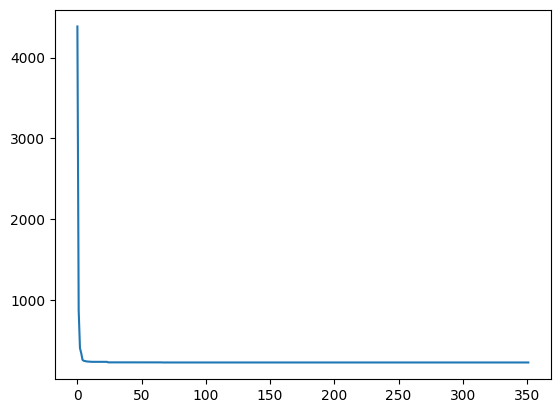

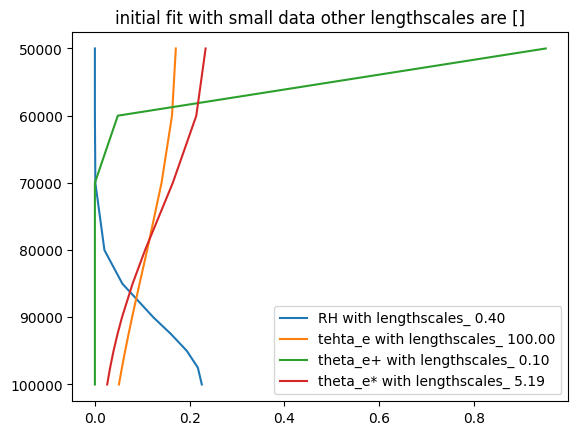

In [82]:
@dataclass
class RBF(gpx.kernels.RBF):
    dummy: gpx.kernels.AbstractKernel = gpx.kernels.RBF()

@dataclass
class OrthogonalRBF(OrthogonalRBF):
    dummy: gpx.kernels.AbstractKernel = gpx.kernels.RBF()



# prep fancy kernel for model
# first fit with small data to get init for SVGP
num_data_for_init=200
D_small = VerticalDataset(
    X2d = X2d[:num_data_for_init,:],
    X3d = X3d[:num_data_for_init,:,:],
    Xstatic = Xstatic[:num_data_for_init,:],
    y=Y[:num_data_for_init,:],
)

lengthscale_bij = tfb.SoftClip(jnp.array(1e-1, dtype=jnp.float64),jnp.array(1e2, dtype=jnp.float64))
variance_bij = tfb.SoftClip(jnp.array(1e-5, dtype=jnp.float64),jnp.array(1e1, dtype=jnp.float64))
noise_bij = tfb.SoftClip(jnp.array(1e-3, dtype=jnp.float64),jnp.array(1e0, dtype=jnp.float64))

smoother = VerticalSmoother(
    jnp.array([[0.0]*num_3d_variables]), 
    jnp.array([[1.0]*num_3d_variables]), 
    Z_levels=pressure_levels)
smoother_input_scale_bij = tfb.SoftClip(jnp.array(1e-2, dtype=jnp.float64),jnp.array(2.0, dtype=jnp.float64))
smoother_mean_bij = tfb.SoftClip(jnp.array(jnp.min(smoother.Z_levels), dtype=jnp.float64),jnp.array(jnp.max(smoother.Z_levels), dtype=jnp.float64))
smoother = smoother.replace_bijector(smoother_mean=smoother_mean_bij,smoother_input_scale=smoother_input_scale_bij)

#base_kernels= [RBF(lengthscale=jnp.array([1.0]), active_dims=[i]).replace_bijector(lengthscale=lengthscale_bij).replace_trainable(variance=False) for i in range(num_variables)]
base_kernels= [OrthogonalRBF(lengthscale=jnp.array([1.0]), active_dims=[i]).replace_bijector(lengthscale=lengthscale_bij) for i in range(num_variables)]
max_interaction = 2
kernel = gpx.kernels.AdditiveKernel(kernels=base_kernels,interaction_variances=jnp.array([1.0/(max_interaction + 1)]*(max_interaction + 1)), max_interaction_depth=max_interaction).replace_bijector(interaction_variances=variance_bij)

prior = gpx.gps.Prior(mean_function= gpx.mean_functions.Zero(), kernel = kernel)
likelihood = gpx.likelihoods.Gaussian(num_datapoints=num_data_for_init, obs_stddev=1e-1).replace_bijector(obs_stddev=noise_bij)#.replace_trainable(obs_stddev=False)
# posterior = CustomConjugatePosterior(prior=prior, likelihood=likelihood, smoother=smoother)
posterior = CustomAdditiveConjugatePosterior(prior=prior, likelihood=likelihood, smoother=smoother)

plt.figure()
objective = jax.jit(CustomConjugateMLL(negative=True))
# opt_posterior, history = gpx.fit(
#     model=posterior,
#     objective=objective,
#     train_data=D_small,
#     optim=ox.adam(learning_rate=1e-2),
#     num_iters=1_000,
#     key=jr.PRNGKey(42),
#     safe=False,
# )
opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=objective,
    train_data=D_small,
    safe=False,
)
plt.plot(history)
plot_params(opt_posterior, title="initial fit with small data")
print(f"noise is {opt_posterior.likelihood.obs_stddev}")
print(f"interaction vars is {opt_posterior.prior.kernel.interaction_variances}")


In [6]:
# # choose inducing inputs and init SVGP
# num_inducing = 200
# # z = jr.normal(key, (num_inducing , num_variables)) # allow this
# z = opt_posterior.smoother.smooth_data(D_small)[0][:num_inducing,:]


# init_posterior_at_inducing = opt_posterior.predict(z, D_small)
# D_full = VerticalDataset(
#     X2d = X2d[:N_train,:],
#     X3d = X3d[:N_train,:,:],
#     Xstatic = Xstatic[:N_train,:],
#     y=Y[:N_train,:],
# )
# # todo try whitening ?
# q = gpx.variational_families.VariationalGaussian(
#     posterior=opt_posterior, 
#     inducing_inputs=z,
#     variational_mean= init_posterior_at_inducing.mean()[:,None],
#     variational_root_covariance= jnp.linalg.cholesky(init_posterior_at_inducing.covariance() + 1e-3 * jnp.eye(num_inducing)), # todo check this is right!
# )

# q = q.replace_trainable(inducing_inputs=False)
# # q = q.replace_trainable(variational_mean=False)
# # q = q.replace_trainable(variational_root_covariance=False)

# objective = jax.jit(CustomELBO(negative=True))
# def zero_grads():
#     def init_fn(_): 
#         return ()
#     def update_fn(updates, state, params=None):
#         return jax.tree_map(jnp.zeros_like, updates), ()
#     return ox.GradientTransformation(init_fn, update_fn)

# optim_pytree = q.replace(
#     posterior = ox.adamw(1e-3), 
#     variational_mean = ox.adamw(1e-2),
#     variational_root_covariance = ox.adamw(1e-2), 
#     inducing_inputs= ox.adamw(1e-2),
#     )

# optim = optim_builder(optim_pytree)

# opt_q, history = gpx.fit(
#     model=q,
#     objective=objective,
#     train_data=D_full,
#     optim=optim,
#     num_iters=500,
#     key=jr.PRNGKey(42),
#     batch_size=512,
#     safe=False,
# )

# plt.figure()
# plt.plot(history)
# plot_params(opt_q, title="full fit")

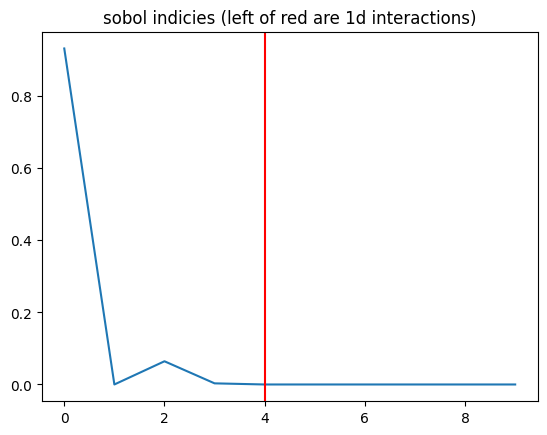

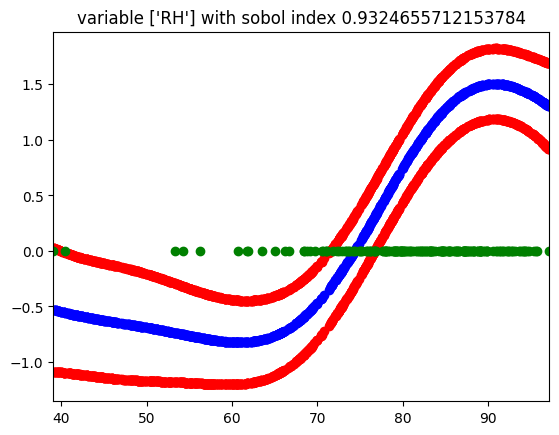

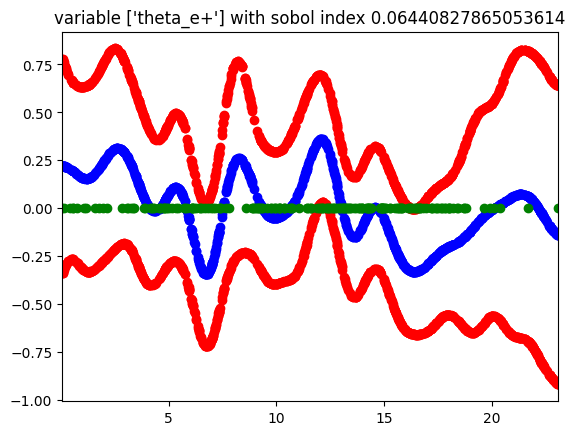

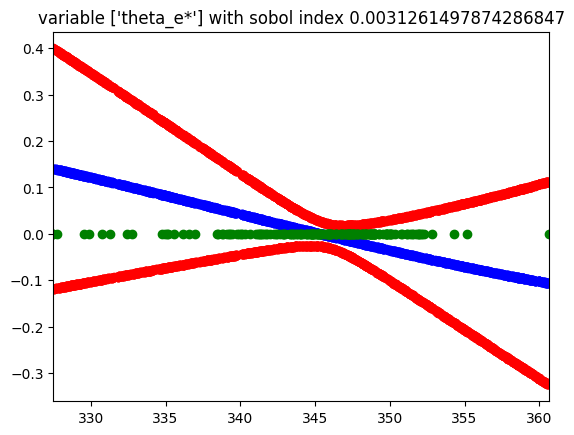

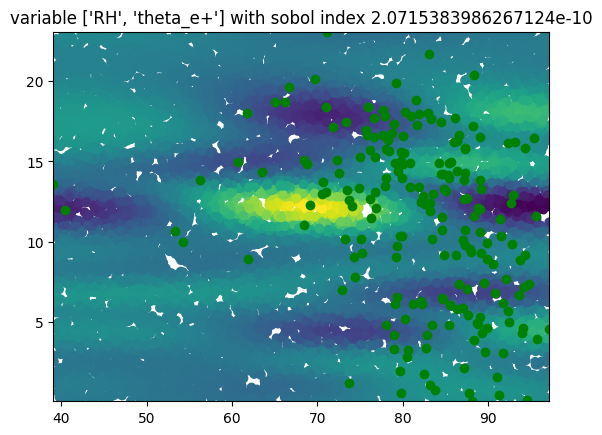

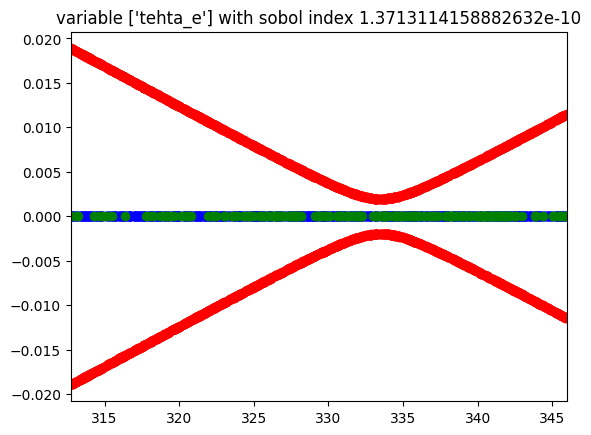

In [83]:

idx_1 = [[i] for i in range(num_variables)]
idx_2 = []
for i in range(num_variables):
    for j in range(i+1,num_variables):
        idx_2.append([i,j])
idxs = idx_1 + idx_2       
sobols = opt_posterior.get_sobol_indicies(D_small, idxs)
sobols = sobols / jnp.sum(sobols)
plt.plot(sobols)
plt.title("sobol indicies (left of red are 1d interactions)")
plt.axvline(x=num_variables, color="red")
k=5
top_idx = jax.lax.top_k(sobols, k)[1]
plot_just_data = False
for idx in top_idx:
    chosen_idx = idxs[idx]
    plt.figure()
    num_plot = 1_000 if len(chosen_idx)==1 else 10_000
    x_train = opt_posterior.smoother.smooth_data(D_small)[0]
    x_plot = jr.uniform(key, (num_plot, num_variables), minval=jnp.min(x_train, axis=0), maxval=jnp.max(x_train, axis=0))
   
    posterior_dist = opt_posterior.predict_additive_component(x_plot, D_small, chosen_idx)
    posterior_dist_at_data = opt_posterior.predict_additive_component(x_train, D_small, chosen_idx)
    x_train = x_train * X_std + X_mean
    x_plot = x_plot * X_std + X_mean
    mean = posterior_dist.mean()
    mean_at_data = posterior_dist_at_data.mean()
    std = jnp.sqrt(posterior_dist.variance())

    if len(chosen_idx)==1:
        if plot_just_data:
            plt.scatter(x_train[:,chosen_idx[0]],mean_at_data, color="blue")
        else:
            plt.scatter(x_plot[:,chosen_idx[0]],mean, color="blue") 
            plt.scatter(x_plot[:,chosen_idx[0]],mean+ 1.96*std, color="red") 
            plt.scatter(x_plot[:,chosen_idx[0]],mean- 1.96*std, color="red") 
            plt.scatter(x_train[:,chosen_idx[0]],jnp.zeros_like(x_train[:,chosen_idx[0]]), color="green")
            plt.xlim([jnp.min(x_train[:,chosen_idx[0]]),jnp.max(x_train[:,chosen_idx[0]])])
    elif len(chosen_idx)==2:
        if plot_just_data:
            plt.scatter(x_train[:,chosen_idx[0]],x_train[:,chosen_idx[1]], c=mean_at_data)
        else:
            plt.scatter(x_plot[:,chosen_idx[0]],x_plot[:,chosen_idx[1]],c=mean)
            plt.scatter(x_train[:,chosen_idx[0]],x_train[:,chosen_idx[1]], color="green")
            plt.xlim([jnp.min(x_train[:,chosen_idx[0]]),jnp.max(x_train[:,chosen_idx[0]])])
            plt.ylim([jnp.min(x_train[:,chosen_idx[1]]),jnp.max(x_train[:,chosen_idx[1]])])
    plt.title(f"variable {[names[i] for i in chosen_idx]} with sobol index {sobols[idx]}")